# Import Dependencies

In [1]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
from PIL import Image
import os

In [2]:
print(len(tf.config.list_physical_devices('GPU')))

1


# Set Paths 

In [3]:
VIDEO_PATH = '/home/jetson/Documents/Robotics/videos'
DATA_PATH = "/home/jetson/Documents/Robotics/data"
IMAGE_PATH = os.path.join(DATA_PATH, 'images')
INTERSECTION_PATH = os.path.join(DATA_PATH, 'intersection')
LANE_PATH = os.path.join(DATA_PATH, 'lane')
MODEL_PATH = '/home/jetson/Documents/Robotics/Tensorflow'

# Change these variables to where your data is stored from running the tensorflow_data_collection.py file. 


# Create and Standardize Image Datasets

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
'''
1. Sets constant dimensions and batch size for images. 
2. Passed directory that containes DESIRED LABELS as sub-folders; see example above
3. Use the image_dataset_from_directory function from TensorFlow to partition data. We use 
   an 80/20 split and change the image size to the predefined values given.
'''

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 17810 files belonging to 2 classes.
Using 14248 files for training.
Found 17810 files belonging to 2 classes.
Using 3562 files for validation.


In [6]:
#Print class names
class_names = train_ds.class_names
print(class_names)


['intersection', 'lane']


In [7]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

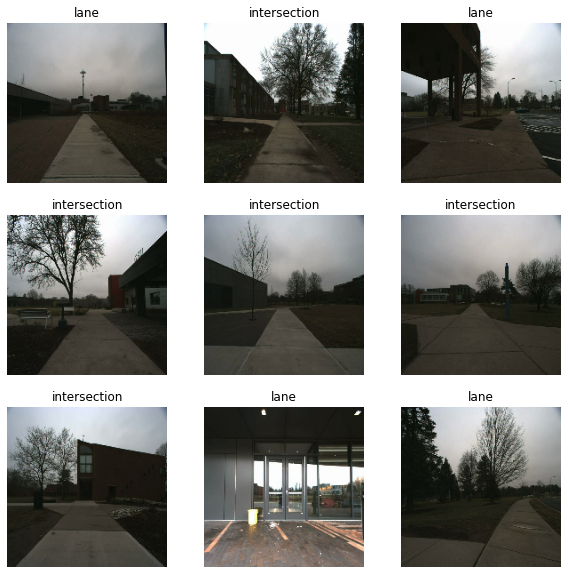

In [8]:
#Plot some example images and respective labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Dataset Configuration (for performance)

In [9]:
#Standardizing Data (converting RBG channels that range from [0, 255] to [0, 1]) through a lambda function
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Create CNN Model

In [10]:
tf.debugging.set_log_device_placement(True)

num_classes = len(class_names) #2 classes

with tf.device('/GPU:0'):
    
    model = Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
      layers.Dense(num_classes, name="outputs")
    ])

In [11]:
with tf.device('/GPU:0'):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# Train Model

In [13]:
epochs=5 #Good number for loss to reach a global minimum

with tf.device('/GPU:0'):
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )


Epoch 1/5
446/446 [==============================] - 608s 1s/step - loss: 0.7838 - accuracy: 0.7132 - val_loss: 0.5821 - val_accuracy: 0.7482
Epoch 2/5
446/446 [==============================] - 591s 1s/step - loss: 0.4935 - accuracy: 0.8234 - val_loss: 0.3958 - val_accuracy: 0.8897
Epoch 3/5
446/446 [==============================] - 596s 1s/step - loss: 0.3708 - accuracy: 0.9034 - val_loss: 0.2920 - val_accuracy: 0.9368
Epoch 4/5
446/446 [==============================] - 594s 1s/step - loss: 0.3144 - accuracy: 0.9279 - val_loss: 0.3232 - val_accuracy: 0.9256
Epoch 5/5
446/446 [==============================] - 593s 1s/step - loss: 0.2821 - accuracy: 0.9407 - val_loss: 0.2374 - val_accuracy: 0.9618


# Visualize Results

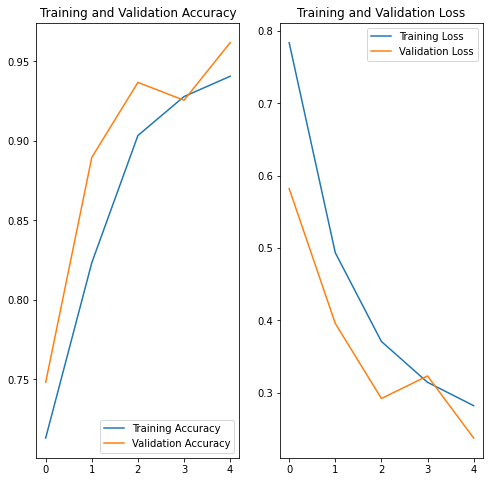

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Save Model for Inference (optional)

In [15]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

model.save(os.path.join(MODEL_PATH, 'jetson_cnn.h5'))

# Load Trained Model and Predict

In [16]:
#Prevents the need to retrain a fresh model with every Python kernel refresh. 
model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'jetson_cnn.h5'))

In [17]:
def predict_image(image):
    '''
    Predicts if there is an intersection ahead. Requires a PIL Image as input
    '''
    img_width = 180
    img_height = 180
    dim = (img_width, img_height)
    
    image = image.resize(dim)
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return score

In [19]:
import cv2

dim = (img_height, img_width)
cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, 'output.ogv')) #Opens video using OpenCV

while cap.isOpened():
    ret, frame = cap.read()
    
    cv2.imshow('Frame',frame)
    
    snap = Image.fromarray(frame.astype('uint8'), 'RGB')
    prediction, score = predict_image(snap)
    confidence = 100*np.max(score)
    if (confidence >= 25):
        print(0) #Lane prediction
    else:
        print(1) #Intersection prediction
#     print(class_names[np.argmax(score)] + "-" + str(100*np.max(score)))
    
    print(confidence)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1
0.6803447846323252
1
0.6819064263254404
1
0.6816990673542023
1
0.6814815104007721
1
0.6824206560850143
1
0.6805452518165112
1
0.6812433712184429
1
0.680426973849535
1
0.6807008758187294
1
0.6811633240431547
1
0.6818037014454603
1
0.6825545337051153
1
0.680264551192522
1
0.6787077523767948
1
0.6812330335378647
1
0.6827426608651876
1
0.6808705627918243
1
0.6810078863054514
1
0.679625989869237
1
0.6814646534621716
1
0.6822688039392233
1
0.681288493797183
1
0.6830447353422642
1
0.6816848646849394
1
0.6802091840654612
1
0.6798052228987217
1
0.6797557696700096
1
0.6795278284698725
1
0.67929164506495
1
0.6767414510250092
1
0.6771101150661707
1
0.6792083848267794
1
0.678212521597743
1
0.6787050981074572
1
0.6766798440366983
1
0.6767542567104101
1
0.6761061027646065
1
0.6786755751818419
1
0.6792311556637287
1
0.6768561899662018
1
0.6779559422284365
1
0.6783657241612673
1
0.6764113437384367
1
0.6751835346221924
1
0.6778907030820847
1
0.6763524375855923
1
0.6788276135921478
1
0.677825603634119


0
99.51521158218384
0
99.6757447719574
0
99.80077147483826
0
99.930739402771
0
99.94224309921265
0
99.93155002593994
0
99.81638789176941
0
99.8578667640686
0
99.45278763771057
0
99.42850470542908
0
99.3983805179596
0
98.11837673187256
0
96.9247817993164
0
94.31566596031189
0
94.84960436820984
0
95.8369493484497
0
96.15392684936523
0
94.11442875862122
0
74.85187649726868
0
72.26529121398926
0
63.158100843429565
0
68.55691075325012
0
39.474982023239136
0
29.058831930160522
0
25.15438199043274
1
10.5172798037529
1
8.08698758482933
1
6.954990327358246
1
3.6070089787244797
1
8.92164409160614
1
10.508961975574493
1
9.378774464130402
1
7.037140429019928
1
5.377449840307236
1
4.749076813459396
1
4.918395355343819
1
3.197377920150757
1
2.45310515165329
1
2.743830531835556
1
1.61057747900486
1
2.0950382575392723
1
0.9970660321414471
1
1.94443017244339
1
1.8970055505633354
1
2.187209390103817
1
2.523798495531082
1
1.5342372469604015
1
1.4877858571708202
1
1.1956162750720978
1
1.2941488064825535
1